In [1]:
!pip install statsmodels


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

plt.rcParams.update({'font.size': 18})

In [3]:
def import_everything(loc):
    df = pd.read_csv(loc)
    df['origin_time'] = df.origin_time.apply(pd.to_datetime)
    df.sort_values(by='origin_time', inplace=True)
    df['t'] = df.origin_time.diff().apply(lambda t: t.total_seconds()).fillna(0)
    df['ct'] = df['t'].cumsum()
    n_total = df.shape[0]
    df = df[df.depth.between(140, 410)].copy()
    df = df[~(df.relative_depth > 70)].copy()
    df = df[~(df.relative_depth < 0)].copy()
    print(f'events removed outside of depth 140 to 410m: total:{n_total}; total removed:{n_total - df.shape[0]}; percent:{(n_total - df.shape[0])/n_total}')
    return df

events removed outside of depth 140 to 410m: total:586; total removed:102; percent:0.17406143344709898


<Axes: >

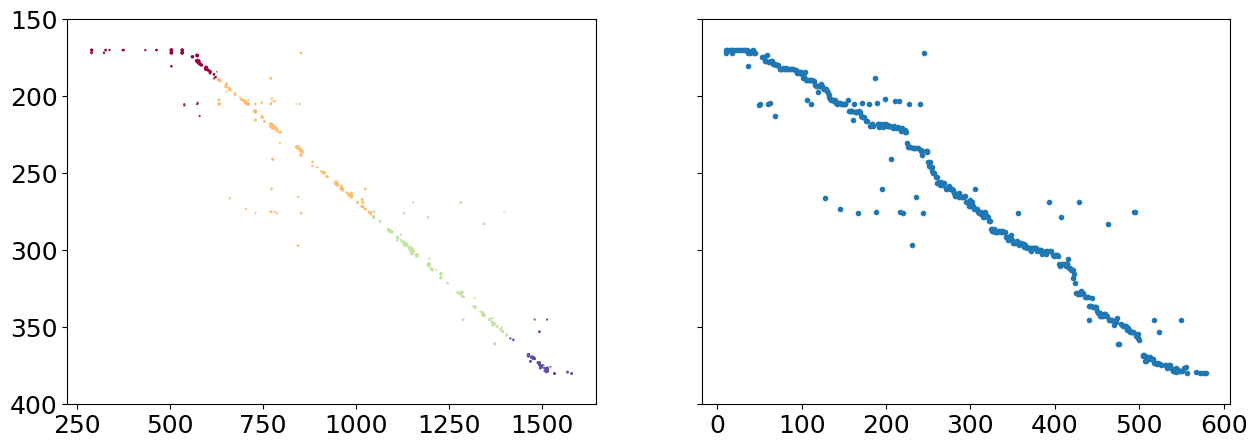

In [4]:
df211 = import_everything('211everything.csv')

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax[0].scatter(df211.ct, df211.depth, marker='.', c=df211.phone_number, cmap='Spectral', s=df211.max_amp)
ax[0].set_ylim(400, 150)
df211.depth.plot(linestyle='', marker='.', ax=ax[1])


events removed outside of depth 140 to 410m: total:1216; total removed:141; percent:0.11595394736842106


<Axes: >

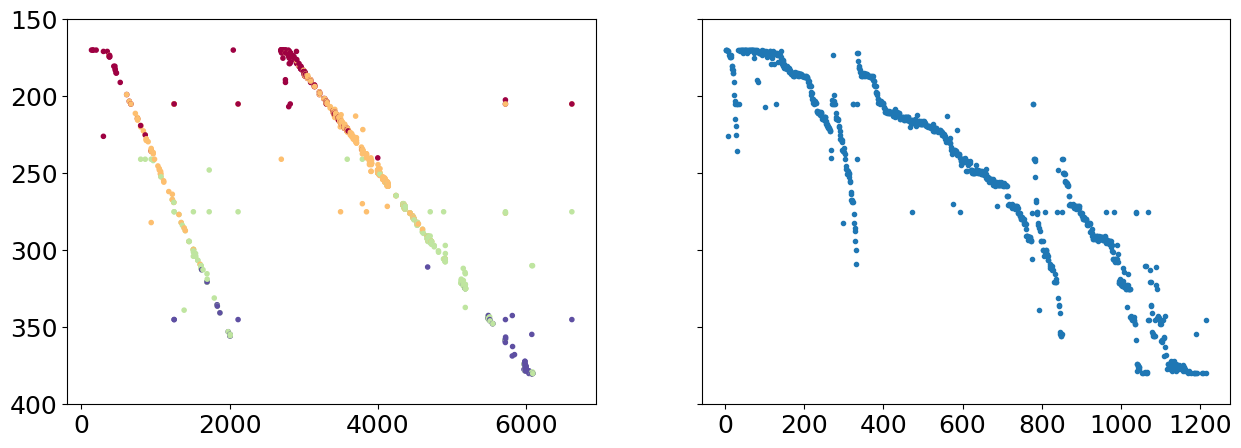

In [5]:
df197 = import_everything('197everything.csv')

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax[0].scatter(df197.ct, df197.depth, marker='.', c=df197.phone_number, cmap='Spectral')
ax[0].set_ylim(400, 150)
df197.depth.plot(linestyle='', marker='.', ax=ax[1])


events removed outside of depth 140 to 410m: total:4009; total removed:867; percent:0.21626340733349964


<Axes: >

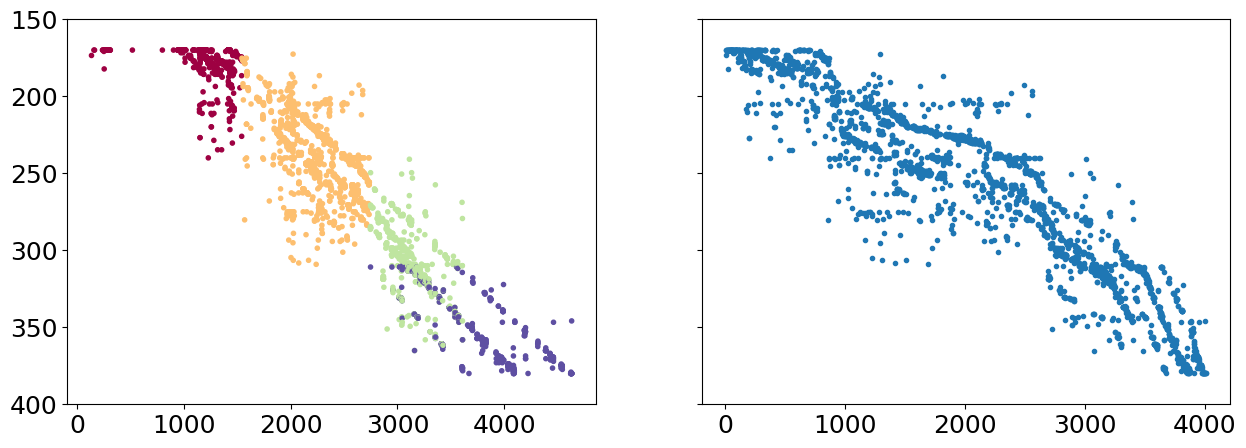

In [6]:
df188 = import_everything('188everything.csv')

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax[0].scatter(df188.ct, df188.depth, marker='.', c=df188.phone_number, cmap='Spectral')
ax[0].set_ylim(400, 150)
df188.depth.plot(linestyle='', marker='.', ax=ax[1])


events removed outside of depth 140 to 410m: total:2954; total removed:208; percent:0.07041299932295193


<Axes: >

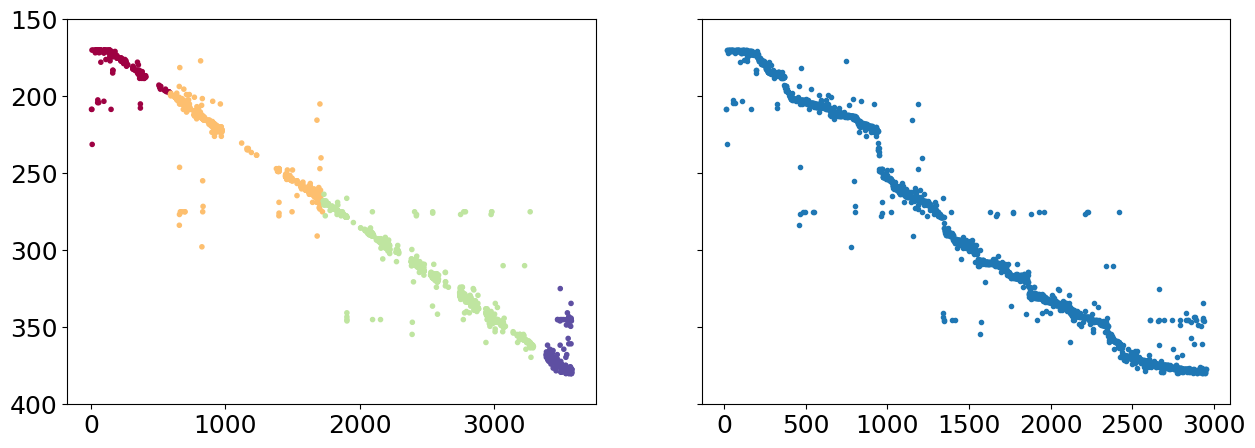

In [7]:
df141 = import_everything('141everything.csv')

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax[0].scatter(df141.ct, df141.depth, marker='.', c=df141.phone_number, cmap='Spectral')
ax[0].set_ylim(400, 150)
df141.depth.plot(linestyle='', marker='.', ax=ax[1])

In [8]:
# df188['dt'] = np.abs(df188.t1 - df188.t2)
# df188 = df188[df188.dt < 0.4].copy()
# df188.shape

velocity: 0.056884666524825496; rsquared: 0.9756871055506444
velocity: 0.06166376828737626; rsquared: 0.9474225416662901
velocity: 0.1026724738101727; rsquared: 0.9612771132322772
velocity: 0.06339576664378399; rsquared: 0.9899403458056009
velocity: 0.1911220362562298; rsquared: 0.9821063379234656


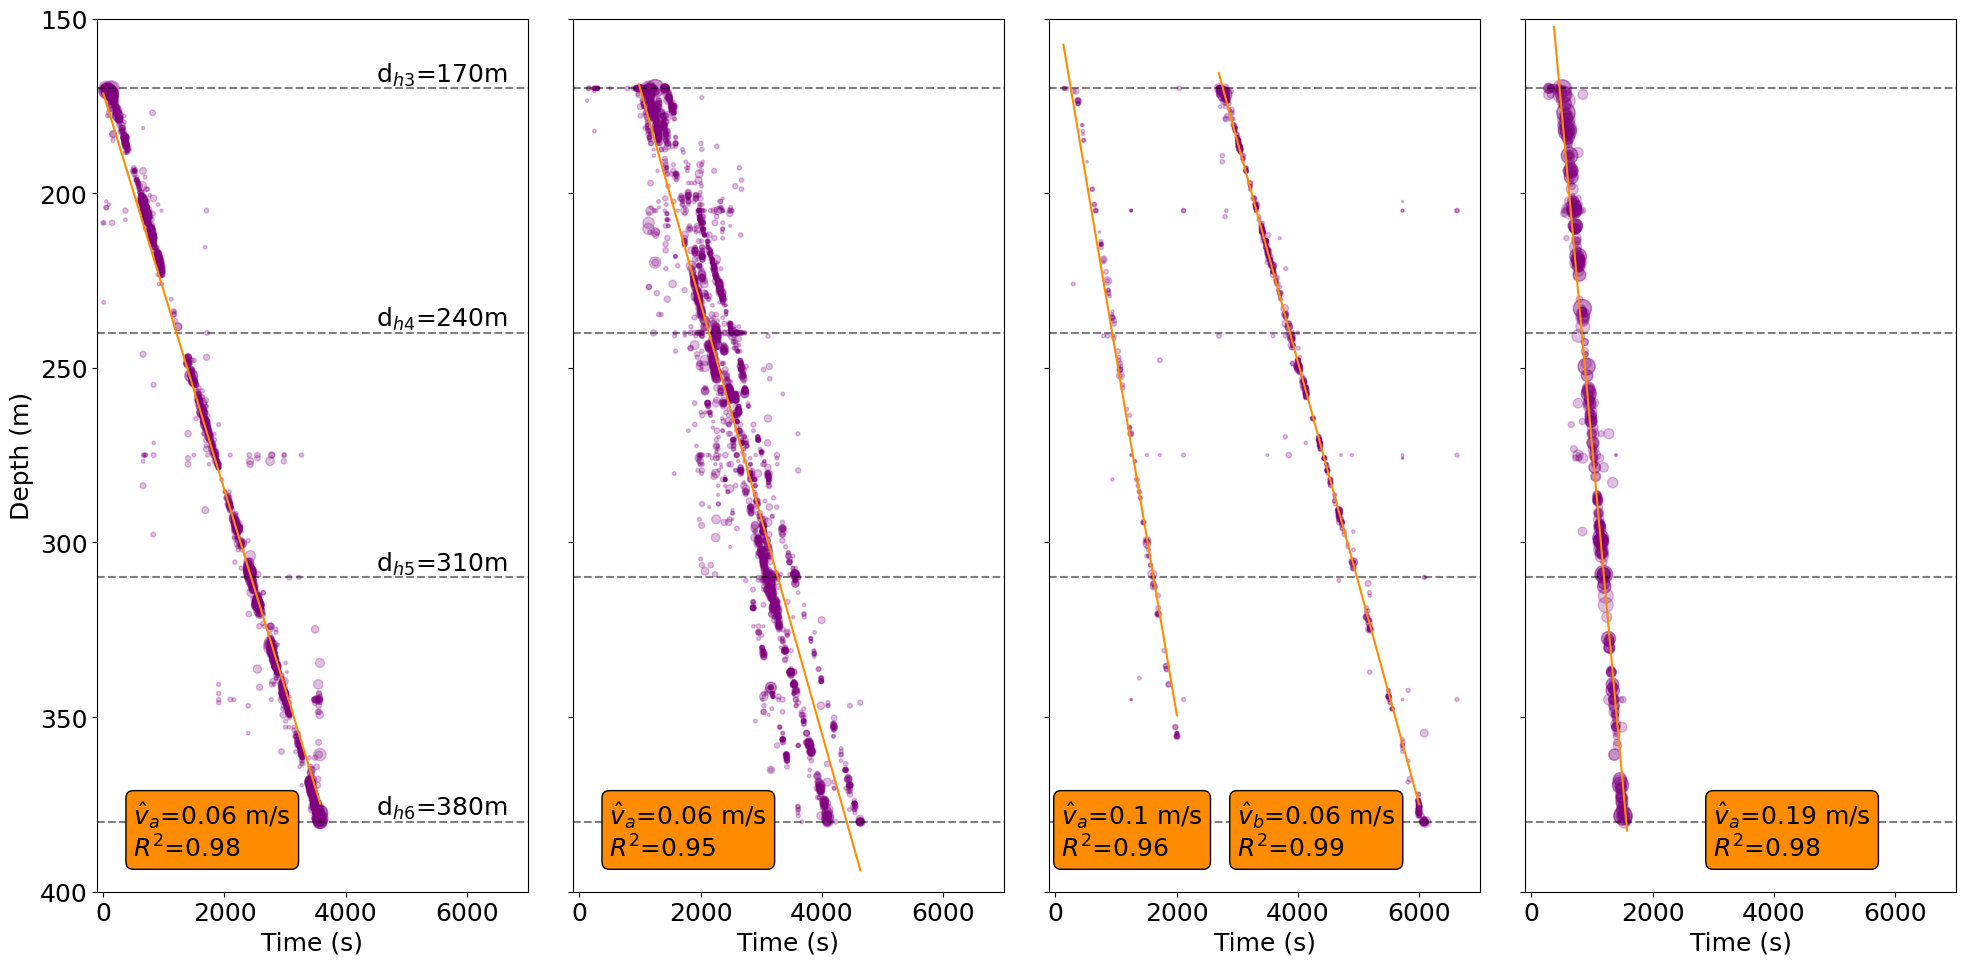

In [139]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, 4, figsize=(20, 10), sharey=True, sharex=True)
ax[0].set_ylim(400, 150)
ax[0].set_xlim(-100, 7000)

ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[2].set_xlabel('Time (s)')
ax[3].set_xlabel('Time (s)')

ax[0].set_ylabel('Depth (m)')

for a in ax:
    a.plot((-100, 10000), (170, 170), linestyle='--', color='black', alpha=0.5)
    a.plot((-100, 10000), (240, 240), linestyle='--', color='black', alpha=0.5)
    a.plot((-100, 10000), (310, 310), linestyle='--', color='black', alpha=0.5)
    a.plot((-100, 10000), (380, 380), linestyle='--', color='black', alpha=0.5)

ax[0].scatter(df141.ct, df141.depth, marker='.', c='purple', s=df141.max_amp*50, alpha=0.25)
ax[1].scatter(df188.ct, df188.depth, marker='.', c='purple', s=df188.max_amp*50, alpha=0.25)
ax[2].scatter(df197.ct, df197.depth, marker='.', c='purple', s=df197.max_amp*50, alpha=0.25)
ax[3].scatter(df211.ct, df211.depth, marker='.', c='purple', s=df211.max_amp*50, alpha=0.25)

def wls_fit_plot(df, ax, ab=False):
    y = df.depth.values
    # X = df.ct.values
    X = df['ct'].values
    X = sm.add_constant(X)
    # X[:,0] = X[:,0]/2
    # w = df.max_amp.values
    td = pd.to_datetime('2020-01-01 12:00:00') - pd.to_datetime('2020-01-01 11:59:30')
    w = df.set_index('origin_time').rolling(td).depth.count().values

    mod_wls = sm.WLS(y, X, weights=1.0 / (w ** 2), hasconst=True)
    res_wls = mod_wls.fit()
    # print(res_wls.summary())
    print(f'velocity: {res_wls.params[1]}; rsquared: {res_wls.rsquared}')
    predy = res_wls.get_prediction().summary_frame()['mean'].values

    ax.plot(X[:,1], predy, color='darkorange')
    props = dict(boxstyle='round', facecolor='darkorange')
    if ab == 'a':
        ax.text(s='$\hat{v}_a$'+f'={np.round(res_wls.params[1], 2)} m/s' + '\n' + f'$R^2$={np.round(res_wls.rsquared, 2)}'
           ,x=100, y=390, bbox=props)
    elif ab == 'b':
        ax.text(s='$\hat{v}_b$'+f'={np.round(res_wls.params[1], 2)} m/s' + '\n' + f'$R^2$={np.round(res_wls.rsquared, 2)}'
           ,x=3000, y=390, bbox=props)
    elif ab == 211:
        ax.text(s='$\hat{v}_a$'+f'={np.round(res_wls.params[1], 2)} m/s' + '\n' + f'$R^2$={np.round(res_wls.rsquared, 2)}'
           ,x=3000, y=390, bbox=props)
    else:
        ax.text(s='$\hat{v}_a$'+f'={np.round(res_wls.params[1], 2)} m/s' + '\n' + f'$R^2$={np.round(res_wls.rsquared, 2)}'
           ,x=500, y=390, bbox=props)
    return X[:,1], predy
    

wls_fit_plot(df141, ax[0])
wls_fit_plot(df188[40:], ax[1])
wls_fit_plot(df197[:150], ax[2], 'a')
wls_fit_plot(df197[160:-30], ax[2], 'b')
X, predy = wls_fit_plot(df211[10:], ax[3], 211)

ax[0].text(s='d$_{h3}$=170m', x=4500, y=168)
ax[0].text(s='d$_{h4}$=240m', x=4500, y=238)
ax[0].text(s='d$_{h5}$=310m', x=4500, y=308)
ax[0].text(s='d$_{h6}$=380m', x=4500, y=378)

# y = df141.depth.values
# X = df141.ct.values
# X = sm.add_constant(X)
# w = df141.max_amp
# w = np.ones_like(w)

# mod_wls = sm.WLS(y, X, weights=1.0 / (w ** 2))
# mod_wls = sm.WLS(y, X, weights=1.0 / (w ** 2), hasconst=True)
# res_wls = mod_wls.fit()
# print(res_wls.summary())
# predy = res_wls.get_prediction().summary_frame()['mean'].values

# ax[0].plot(X[:,1], predy, color='darkorange')
# # cbar_ax = fig.add_axes([0.95, 0.15, 0.005, 0.7])
# fig.colorbar(cbar, cax=cbar_ax, label='Maximum Amplitude (Pa)')

fig.tight_layout()
fig.savefig('fig4.pdf', bbox_inches='tight')

(150.0, 400.0)

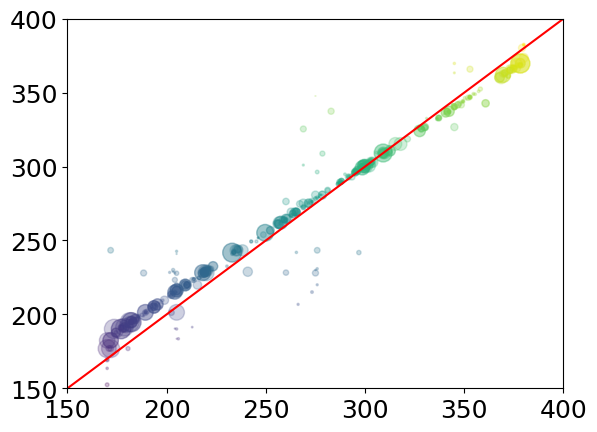

In [134]:
plt.scatter(df211[10:].depth, predy, c=df211[10:].ct, s=df211[10:].max_amp**2, alpha=0.25)
plt.plot((150, 400), (150, 400), color='red')
plt.ylim(150, 400)
plt.xlim(150, 400)

In [84]:
td = pd.to_datetime('2020-01-01 12:00:00') - pd.to_datetime('2020-01-01 11:59:00')
df211.set_index('origin_time').rolling(td).depth.count().values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  5.,  6.,  2.,  2.,
        3.,  3.,  4.,  5.,  6.,  7.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23., 24., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 44.,
       45., 37., 38., 39., 40., 41., 42., 43., 44., 45., 32., 33., 34.,
       35., 36., 37., 31., 32., 28., 28., 22., 23., 24., 24., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.,
       37., 36., 37., 38., 38., 39., 37., 38., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 56., 52., 48., 49., 50

In [140]:
df141.to_csv('depths141.csv', )
df188.to_csv('depths188.csv', )
df197.to_csv('depths197.csv', )
df211.to_csv('depths211.csv', )


In [ ]:
df141.columns

In [ ]:
df141['t+t1'] = (df141['t'] - df141.shift(1)['t']).fillna(0)
df141['t-t1'] = (df141['t'] - df141.shift(-1)['t']).fillna(0)

In [ ]:
df141[['depth','t','max_amp', 't+t1', 't-t1']].corr()

In [ ]:
ax = df141.plot.scatter('t+t1', 't-t1', c='depth', vmin=150, vmax=400, cmap='magma', marker='.',)
ax.plot((0, 0), (-200, 200)     , alpha=0.25, color='black',)
ax.plot((-200, 200), (0, 0)     , alpha=0.25, color='black',)
ax.plot((-200, 200), (-200, 200), alpha=0.25, color='black',)
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)

In [ ]:
df188['t+t1'] = (df188['t'] - df188.shift(1)['t']).fillna(0)
df188['t-t1'] = (df188['t'] - df188.shift(-1)['t']).fillna(0)
ax = df188.plot.scatter('t+t1', 't-t1', c='depth', vmin=150, vmax=400, cmap='magma', marker='.',)


In [ ]:
test = pd.DataFrame({'data':[2, 5, 4, 5, 3, 2, 6, 11, 2, 4]})
test['test.diff()'] = test.diff()
test['test.data.diff().fillna(test.data)'] = test.data.diff().fillna(test.data)
test['test.shift(-1).data.diff()'] = test.shift(-1).data.diff()
test

In [ ]:
test.data - test.shift(1).data

In [ ]:
test.data - test.shift(-1).data

In [ ]:
df141[df141.depth > 400]

In [ ]:
df141[df141.dt < -0.04].depth.hist()